In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans, DBSCAN, MeanShift, HDBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import defaultdict
from tqdm import tqdm
from scipy.linalg import inv

PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [24]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[7], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='full_window', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
                    #   mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')

da.load_results_da()
center_idx_ctxt = da.queries[-1].get_center_idx()
winsize_ctxt = da.queries[-1].winsize
if center_idx_ctxt < 0:
    center_idx_ctxt = winsize_ctxt + center_idx_ctxt
da.seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

Initializing T1029-D1 ...
Results already exist
Casp ID: T1029-D1 	PDB: 6uf2
Structure exists: 'pdb/pdb6uf2.ent' 
UniProt ID: Q31PX7


In [ ]:
# T1030: -HHHHHHHHHHHHHHH-------HHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHH----------EEHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH------HHHHHHHHHHHHHHHHHHH---------HHHHHHHHH-----------EE----HHHHHHHHHHHHHHHHHHHHHH------
# T1029: MRIDELVPADPRAVSLYTPYYSQANRRRYLPYALSLYQGSSIEGSRAVEGGAPISFVATWTVTPLPADMTRCHLQFNNDAELTYEILLPNHEFLEYLIDMLMGYQRMQKTDFPGAFYRRLLGYDS

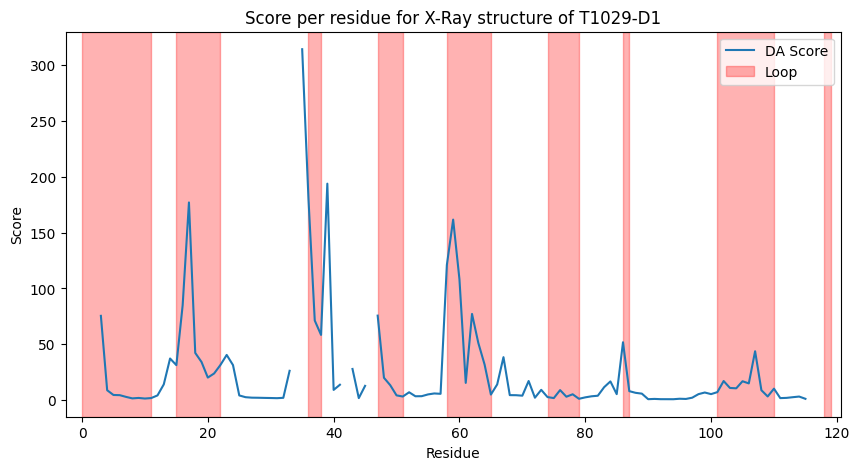

In [26]:
# import re
# with open('seq.ss', 'r') as file:
#     sequence = ""
#     ss = ""
#     conf = ""
    
#     for line in file:
#         if line.startswith("seq:"):
#             # Extract sequence part from the line
#             sequence += line.split()[2]
#         elif line.startswith("SS:"):
#             # Extract secondary structure part from the line
#             ss += line.split()[1]
#         elif line.startswith("conf:"):
#             # Extract confidence part from the line
#             conf += line.split()[1]

# jpred_map = {'H': 0, 'E': 1, 'c': 2, 'C': 2, '-': 3}
jpred_map = {'H': 0, 'E': 1, '-': 2}
# H = alpha helix, E = beta strand, - = other
jpred_map_inv = {v: k for k, v in jpred_map.items()}

ss = '--------------EEE--------HHHHHHHHHHHHH---EEEEEEEE-----EEEEEE--------EEEEEEEE------EEEEEE--HHHHHHHHHHHHH----------HHHHHHHH----'
jpred = []
j = 0
i = 0
while(i < len(da.xray_phi_psi)):
    row = da.xray_phi_psi.iloc[i]
    if da.sequence[j] == row['res']:
        jpred.append(jpred_map[ss[j]])
        j += 1
        i += 1
    else:
        j += 1
da.xray_phi_psi['jpred'] = jpred

running_val = da.xray_phi_psi.iloc[0]['jpred']
bouts = []
bout_start = 0
for i,row in da.xray_phi_psi.iterrows():
    if row['jpred'] != running_val:
        bouts.append((bout_start, i, running_val))
        bout_start = i + 1
        running_val = row['jpred']
bouts.append((bout_start, i, running_val))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(len(da.xray_phi_psi)), da.xray_phi_psi.da, label='DA Score')
for i,bout in enumerate(bouts):
    if bout[2] == 2:
        if i == 0:
            ax.axvspan(bout[0], bout[1], color='red', alpha=0.3, label='Loop')
        else:
            ax.axvspan(bout[0], bout[1], color='red', alpha=0.3)
ax.legend(loc='upper right')
ax.set_title(f'Score per residue for X-Ray structure of {da.casp_protein_id}')
ax.set_xlabel('Residue')
ax.set_ylabel('Score')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(da.phi_psi_predictions, x='pos', y='af_score', label='Average Maha Score')
for i,bout in enumerate(bouts):
    if bout[2] == 2:
        if i == 0:
            ax.axvspan(bout[0], bout[1], color='red', alpha=0.3, label='Loop')
        else:
            ax.axvspan(bout[0], bout[1], color='red', alpha=0.3)
ax.legend(loc='upper right')
ax.set_title(f'Average Score per residue for Predicted Structures of {da.casp_protein_id}')
ax.set_xlabel('Residue')
ax.set_ylabel('Score')
plt.show()